In [1]:
import pandas as pd
import torch
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments)
from transformers import BertForSequenceClassification
import numpy as np
from datasets import Dataset
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ✅ Lista de modelos a probar
"""

model_names = [
      "bert-base-multilingual-cased"
]
"""
model_names = [
    "bert-base-multilingual-cased",
    "dccuchile/bert-base-spanish-wwm-uncased",
    "dccuchile/bert-base-spanish-wwm-cased",
    #"xlm-roberta-base"
]

grid = [
    # 👇 Epochs más largos con LR bajo
    {"learning_rate": 2e-5, "batch_size": 16, "epochs": 5, "weight_decay": 0.01, "warmup_ratio": 0.1},
    {"learning_rate": 2e-5, "batch_size": 32, "epochs": 5, "weight_decay": 0.01, "warmup_ratio": 0.1},

    # 👇 LR intermedio con distintos batch
    {"learning_rate": 3e-5, "batch_size": 16, "epochs": 4, "weight_decay": 0.001, "warmup_ratio": 0.0},
    {"learning_rate": 3e-5, "batch_size": 32, "epochs": 4, "weight_decay": 0.001, "warmup_ratio": 0.1},
    {"learning_rate": 3e-5, "batch_size": 64, "epochs": 4, "weight_decay": 0.001, "warmup_ratio": 0.1},

    # 👇 Exploración con LR alto (arriesgado)
    {"learning_rate": 5e-5, "batch_size": 32, "epochs": 3, "weight_decay": 0.0, "warmup_ratio": 0.0},

    # 👇 Extra: bajo LR con batch más grande (si GPU lo aguanta)
    {"learning_rate": 1e-5, "batch_size": 32, "epochs": 5, "weight_decay": 0.01, "warmup_ratio": 0.1},
    {"learning_rate": 1e-5, "batch_size": 64, "epochs": 5, "weight_decay": 0.01, "warmup_ratio": 0.1},
]

In [3]:
# Verifica si hay GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ✅ Carga de datos
df = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_descripciones.csv", sep="|")

# Fusiona columnas de diagnóstico en texto
diag_cols = [col for col in df.columns if col.startswith("Diag")]
df["text"] = df[diag_cols].fillna("").apply(lambda x: " ".join(x), axis=1)
df["label"] = df["DIAG PSQ"].apply(lambda x: 1 if "Esquizofrenia" in x and "Otros tipos de esquizofrenia" not in x else 0)
seed = int(time.time_ns() % (2**32))
#seed=42
np.random.seed(seed)
# División en train/test
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], stratify=df["label"], test_size=0.2, random_state=seed)
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})
print("Entrenamiento:", Counter(y_train))
print("Evaluación:", Counter(y_test))

Usando dispositivo: cuda
Entrenamiento: Counter({0: 1115, 1: 482})
Evaluación: Counter({0: 279, 1: 121})


Total ejemplos: 1997
Clases únicas: [0 1]


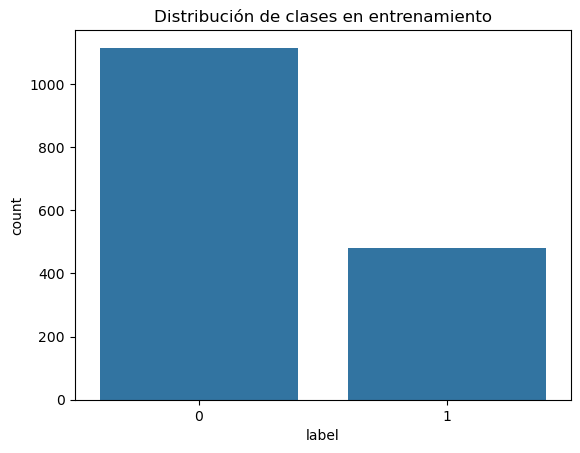

In [4]:
print(f"Total ejemplos: {len(df)}")
print(f"Clases únicas: {df['label'].unique()}")

sns.countplot(x=y_train)
plt.title("Distribución de clases en entrenamiento")
plt.show()

In [5]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds)
    }

def evaluate_model(model_name, learning_rate, batch_size, epochs, weight_decay, warmup_ratio):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(batch):
        return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

    train_tokenized = train_dataset.map(tokenize, batched=True)
    test_tokenized = test_dataset.map(tokenize, batched=True)

    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    training_args = TrainingArguments(
        output_dir="./results/BERT",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        eval_strategy="epoch",
        logging_steps=10,
        disable_tqdm=True,
        save_strategy="no",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=test_tokenized,
        compute_metrics=compute_metrics
    )

    trainer.train()
    metrics = trainer.evaluate()
    print(f"Evaluating {model_name} with learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
    print(f"Accuracy: {metrics['eval_accuracy']:.3f}, F1: {metrics['eval_f1']:.3f}, Precision: {metrics['eval_precision']:.3f}, Recall: {metrics['eval_recall']:.3f}")
    return metrics

In [6]:
# ✅ Loop para probar todos los modelos y combinaciones
resultados = []

for model_name in model_names:
    for params in grid:
        print(f"\n🔍 Probando modelo {model_name} con {params}")
        metrics = evaluate_model(model_name, **params)
        resultados.append({
            "modelo": model_name,
            "learning_rate": params["learning_rate"],
            "batch_size": params["batch_size"],
            "epochs": params["epochs"],
            "accuracy": metrics["eval_accuracy"],
            "f1": metrics["eval_f1"],
            "precision": metrics["eval_precision"],
            "recall": metrics["eval_recall"]
        })
        print(f"Accuracy: {metrics['eval_accuracy']:.3f}, F1: {metrics['eval_f1']:.3f}, Precision: {metrics['eval_precision']:.3f}, Recall: {metrics['eval_recall']:.3f}")

# ✅ Resultados ordenados
df_resultados = pd.DataFrame(resultados).sort_values(by="f1", ascending=False)
print("\n🏆 Mejores resultados por F1:")
print(df_resultados.head(10))

df_resultados["score"] = df_resultados["f1"] * 0.6 + df_resultados["recall"] * 0.4
df_ordenado = df_resultados.sort_values(by="score", ascending=False)
print("\n📊 Mejores modelos por score combinado (f1 + recall):")
print(df_ordenado.head(10))


🔍 Probando modelo bert-base-multilingual-cased con {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 5, 'weight_decay': 0.01, 'warmup_ratio': 0.1}


Map: 100%|██████████| 400/400 [00:00<00:00, 12560.24 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6613, 'grad_norm': 2.186217784881592, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.1}
{'loss': 0.621, 'grad_norm': 2.2646372318267822, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.6054, 'grad_norm': 2.068115472793579, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.6507, 'grad_norm': 3.8003790378570557, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.6024, 'grad_norm': 1.5541812181472778, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.6135, 'grad_norm': 2.9567711353302, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.6}
{'loss': 0.5943, 'grad_norm': 2.8330681324005127, 'learning_rate': 1.9155555555555558e-05, 'epoch': 0.7}
{'loss': 0.5931, 'grad_norm': 8.177886962890625, 'learning_rate': 1.8711111111111113e-05, 'epoch': 0.8}
{'loss': 0.6319, 'grad_norm': 2.2275397777557373, 'learning_rate': 1.826666666666667e-05, 'epoch': 0.9}
{'loss': 0.5557, 'grad_norm': 13.167682647705078, 'learning_rate': 1.782222222

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5541177988052368, 'eval_accuracy': 0.6975, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.2921, 'eval_samples_per_second': 174.512, 'eval_steps_per_second': 10.907, 'epoch': 1.0}
{'loss': 0.528, 'grad_norm': 1.7407029867172241, 'learning_rate': 1.737777777777778e-05, 'epoch': 1.1}
{'loss': 0.5441, 'grad_norm': 4.382128715515137, 'learning_rate': 1.6933333333333336e-05, 'epoch': 1.2}
{'loss': 0.5233, 'grad_norm': 4.42065954208374, 'learning_rate': 1.648888888888889e-05, 'epoch': 1.3}
{'loss': 0.5101, 'grad_norm': 3.7696611881256104, 'learning_rate': 1.6044444444444444e-05, 'epoch': 1.4}
{'loss': 0.4968, 'grad_norm': 279.7633056640625, 'learning_rate': 1.5600000000000003e-05, 'epoch': 1.5}
{'loss': 0.4656, 'grad_norm': 5.225739002227783, 'learning_rate': 1.5155555555555557e-05, 'epoch': 1.6}
{'loss': 0.5704, 'grad_norm': 6.9868597984313965, 'learning_rate': 1.4711111111111111e-05, 'epoch': 1.7}
{'loss': 0.5513, 'grad_norm': 3.785332202911377,

Map: 100%|██████████| 400/400 [00:00<00:00, 12348.81 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6898, 'grad_norm': 2.604456901550293, 'learning_rate': 7.2000000000000005e-06, 'epoch': 0.2}
{'loss': 0.64, 'grad_norm': 6.486822128295898, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.6051, 'grad_norm': 1.6300348043441772, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.6024, 'grad_norm': 3.453134298324585, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.5855, 'grad_norm': 2.149458885192871, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}
{'eval_loss': 0.5500499606132507, 'eval_accuracy': 0.695, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.1757, 'eval_samples_per_second': 183.846, 'eval_steps_per_second': 5.975, 'epoch': 1.0}
{'loss': 0.5486, 'grad_norm': 2.705453872680664, 'learning_rate': 1.697777777777778e-05, 'epoch': 1.2}
{'loss': 0.5226, 'grad_norm': 4.164404392242432, 'learning_rate': 1.608888888888889e-05, 'epoch': 1.4}
{'loss': 0.4703, 'grad_norm': 6.163406848907471, 'le

Map: 100%|██████████| 400/400 [00:00<00:00, 10857.28 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6056, 'grad_norm': 3.7595324516296387, 'learning_rate': 2.9325e-05, 'epoch': 0.1}
{'loss': 0.5933, 'grad_norm': 3.005525827407837, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.6175, 'grad_norm': 1.5173877477645874, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.6428, 'grad_norm': 2.125842332839966, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.5991, 'grad_norm': 1.820029854774475, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.6111, 'grad_norm': 2.7793235778808594, 'learning_rate': 2.5575e-05, 'epoch': 0.6}
{'loss': 0.5813, 'grad_norm': 3.548737049102783, 'learning_rate': 2.4825e-05, 'epoch': 0.7}
{'loss': 0.6086, 'grad_norm': 6.480506420135498, 'learning_rate': 2.4075e-05, 'epoch': 0.8}
{'loss': 0.6451, 'grad_norm': 2.6550395488739014, 'learning_rate': 2.3325e-05, 'epoch': 0.9}
{'loss': 0.5754, 'grad_norm': 3.9292609691619873, 'learning_rate': 2.2575e-05, 'epoch': 1.0}
{'eval_loss': 0.5439292788505554, 'eval_accuracy': 0.71, 'eval_

Map: 100%|██████████| 400/400 [00:00<00:00, 10809.23 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6546, 'grad_norm': 4.278328895568848, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.2}
{'loss': 0.6335, 'grad_norm': 4.6788330078125, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.6127, 'grad_norm': 0.9528065919876099, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.6056, 'grad_norm': 2.93709135055542, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.618, 'grad_norm': 1.7373658418655396, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5731958150863647, 'eval_accuracy': 0.6975, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8202, 'eval_samples_per_second': 219.754, 'eval_steps_per_second': 7.142, 'epoch': 1.0}
{'loss': 0.5812, 'grad_norm': 1.8286114931106567, 'learning_rate': 2.3500000000000002e-05, 'epoch': 1.2}
{'loss': 0.5267, 'grad_norm': 2.5492982864379883, 'learning_rate': 2.1833333333333333e-05, 'epoch': 1.4}
{'loss': 0.4824, 'grad_norm': 6.65864896774292, 'learning_rate': 2.0166666666666668e-05, 'epoch': 1.6}
{'loss': 0.5509, 'grad_norm': 9.272644996643066, 'learning_rate': 1.8500000000000002e-05, 'epoch': 1.8}
{'loss': 0.4935, 'grad_norm': 6.531376361846924, 'learning_rate': 1.6833333333333334e-05, 'epoch': 2.0}
{'eval_loss': 0.4361390769481659, 'eval_accuracy': 0.7675, 'eval_f1': 0.640926640926641, 'eval_precision': 0.6014492753623188, 'eval_recall': 0.6859504132231405, 'eval_runtime': 2.2088, 'eval_samples_per_second': 181.097, 'eval_steps_per_second': 5.886, '

Map: 100%|██████████| 400/400 [00:00<00:00, 11006.79 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6607, 'grad_norm': 6.459327697753906, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.4}
{'loss': 0.6165, 'grad_norm': 2.643965244293213, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5978168249130249, 'eval_accuracy': 0.6975, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.0087, 'eval_samples_per_second': 199.135, 'eval_steps_per_second': 3.485, 'epoch': 1.0}
{'loss': 0.6128, 'grad_norm': 1.1261109113693237, 'learning_rate': 2.3666666666666665e-05, 'epoch': 1.2}
{'loss': 0.5382, 'grad_norm': 1.9246989488601685, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.6}
{'loss': 0.6024, 'grad_norm': 3.592374324798584, 'learning_rate': 1.7e-05, 'epoch': 2.0}
{'eval_loss': 0.49934154748916626, 'eval_accuracy': 0.7375, 'eval_f1': 0.4067796610169492, 'eval_precision': 0.6428571428571429, 'eval_recall': 0.2975206611570248, 'eval_runtime': 1.9863, 'eval_samples_per_second': 201.376, 'eval_steps_per_second': 3.524, 'epoch': 2.0}
{'loss': 0.5295, 'grad_norm': 11.949353218078613, 'learning_rate': 1.3666666666666667e-05, 'epoch': 2.4}
{'loss': 0.5091, 'grad_norm': 4.125844478607178, 'learning_rate': 1.0333333333333333e-05, 'epoch': 2.8

Map: 100%|██████████| 400/400 [00:00<00:00, 12779.62 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6049, 'grad_norm': 1.3014588356018066, 'learning_rate': 4.7e-05, 'epoch': 0.2}
{'loss': 0.6352, 'grad_norm': 3.851144552230835, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.612, 'grad_norm': 3.345876932144165, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.6049, 'grad_norm': 2.5735509395599365, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.5882, 'grad_norm': 1.9522340297698975, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}
{'eval_loss': 0.5155298113822937, 'eval_accuracy': 0.7175, 'eval_f1': 0.13740458015267176, 'eval_precision': 0.9, 'eval_recall': 0.0743801652892562, 'eval_runtime': 2.0211, 'eval_samples_per_second': 197.908, 'eval_steps_per_second': 6.432, 'epoch': 1.0}
{'loss': 0.5501, 'grad_norm': 3.278459310531616, 'learning_rate': 3.0333333333333337e-05, 'epoch': 1.2}
{'loss': 0.4789, 'grad_norm': 7.481362342834473, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.4}
{'loss': 0.4461, 'grad_norm': 3.72952842712402

Map: 100%|██████████| 400/400 [00:00<00:00, 13055.69 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7076, 'grad_norm': 32.802574157714844, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.2}
{'loss': 0.6585, 'grad_norm': 6.103907585144043, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6232, 'grad_norm': 4.313478946685791, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.5956, 'grad_norm': 2.3167173862457275, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.6065, 'grad_norm': 1.8269721269607544, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5809509754180908, 'eval_accuracy': 0.6975, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.3347, 'eval_samples_per_second': 171.325, 'eval_steps_per_second': 5.568, 'epoch': 1.0}
{'loss': 0.5838, 'grad_norm': 6.581417083740234, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.556, 'grad_norm': 2.1313371658325195, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.5265, 'grad_norm': 2.9357705116271973, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.6}
{'loss': 0.6324, 'grad_norm': 2.162815809249878, 'learning_rate': 7.155555555555556e-06, 'epoch': 1.8}
{'loss': 0.5764, 'grad_norm': 3.383863687515259, 'learning_rate': 6.711111111111111e-06, 'epoch': 2.0}
{'eval_loss': 0.5250598788261414, 'eval_accuracy': 0.7175, 'eval_f1': 0.23129251700680273, 'eval_precision': 0.6538461538461539, 'eval_recall': 0.14049586776859505, 'eval_runtime': 2.2895, 'eval_samples_per_second': 174.712, 'eval_steps_per_second': 5.678, 'epo

Map: 100%|██████████| 400/400 [00:00<00:00, 10917.05 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6903, 'grad_norm': 0.957979679107666, 'learning_rate': 6.923076923076923e-06, 'epoch': 0.4}
{'loss': 0.6191, 'grad_norm': 1.5193300247192383, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5975934863090515, 'eval_accuracy': 0.6975, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.3694, 'eval_samples_per_second': 168.816, 'eval_steps_per_second': 2.954, 'epoch': 1.0}
{'loss': 0.609, 'grad_norm': 0.9316139221191406, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.2}
{'loss': 0.5406, 'grad_norm': 1.8447099924087524, 'learning_rate': 7.67857142857143e-06, 'epoch': 1.6}
{'loss': 0.631, 'grad_norm': 2.2240521907806396, 'learning_rate': 6.785714285714287e-06, 'epoch': 2.0}
{'eval_loss': 0.568501889705658, 'eval_accuracy': 0.695, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.5733, 'eval_samples_per_second': 155.44, 'eval_steps_per_second': 2.72, 'epoch': 2.0}
{'loss': 0.5752, 'grad_norm': 1.9055720567703247, 'learning_rate': 5.892857142857144e-06, 'epoch': 2.4}
{'loss': 0.5442, 'grad_norm': 2.2496213912963867, 'learning_rate': 5e-06, 'epoch': 2.8}
{'eval_loss': 0.5220326781272888, 'eval_accuracy': 0.70

Map: 100%|██████████| 400/400 [00:00<00:00, 10701.80 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6773, 'grad_norm': 4.6797871589660645, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.1}
{'loss': 0.6, 'grad_norm': 5.7082695960998535, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.6291, 'grad_norm': 5.035576343536377, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.6413, 'grad_norm': 4.650547027587891, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.5845, 'grad_norm': 4.081450939178467, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.6113, 'grad_norm': 5.612696170806885, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.6}
{'loss': 0.5817, 'grad_norm': 4.494733810424805, 'learning_rate': 1.9155555555555558e-05, 'epoch': 0.7}
{'loss': 0.5582, 'grad_norm': 6.7791666984558105, 'learning_rate': 1.8711111111111113e-05, 'epoch': 0.8}
{'loss': 0.583, 'grad_norm': 6.376906394958496, 'learning_rate': 1.826666666666667e-05, 'epoch': 0.9}
{'loss': 0.4926, 'grad_norm': 7.2203545570373535, 'learning_rate': 1.782222222222

Map: 100%|██████████| 400/400 [00:00<00:00, 11790.03 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6557, 'grad_norm': 2.658188819885254, 'learning_rate': 7.2000000000000005e-06, 'epoch': 0.2}
{'loss': 0.6502, 'grad_norm': 6.182955741882324, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.6063, 'grad_norm': 3.3546366691589355, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.5825, 'grad_norm': 3.390176296234131, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.5598, 'grad_norm': 2.9103076457977295, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}
{'eval_loss': 0.5103712677955627, 'eval_accuracy': 0.74, 'eval_f1': 0.3246753246753247, 'eval_precision': 0.7575757575757576, 'eval_recall': 0.2066115702479339, 'eval_runtime': 2.1776, 'eval_samples_per_second': 183.685, 'eval_steps_per_second': 5.97, 'epoch': 1.0}
{'loss': 0.5084, 'grad_norm': 3.5635414123535156, 'learning_rate': 1.697777777777778e-05, 'epoch': 1.2}
{'loss': 0.4458, 'grad_norm': 4.689907073974609, 'learning_rate': 1.608888888888889e-05, 'epoch': 1.4}
{'los

Map: 100%|██████████| 400/400 [00:00<00:00, 11692.50 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5915, 'grad_norm': 5.681601524353027, 'learning_rate': 2.9325e-05, 'epoch': 0.1}
{'loss': 0.5885, 'grad_norm': 6.222094535827637, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.6233, 'grad_norm': 6.813319683074951, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.6368, 'grad_norm': 4.195123672485352, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.5585, 'grad_norm': 4.365047454833984, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.5901, 'grad_norm': 4.053760528564453, 'learning_rate': 2.5575e-05, 'epoch': 0.6}
{'loss': 0.5714, 'grad_norm': 3.7700297832489014, 'learning_rate': 2.4825e-05, 'epoch': 0.7}
{'loss': 0.5287, 'grad_norm': 6.984731197357178, 'learning_rate': 2.4075e-05, 'epoch': 0.8}
{'loss': 0.6119, 'grad_norm': 6.290489196777344, 'learning_rate': 2.3325e-05, 'epoch': 0.9}
{'loss': 0.5001, 'grad_norm': 7.548818111419678, 'learning_rate': 2.2575e-05, 'epoch': 1.0}
{'eval_loss': 0.5038129091262817, 'eval_accuracy': 0.735, 'eval_f1'

Map: 100%|██████████| 400/400 [00:00<00:00, 12411.94 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6766, 'grad_norm': 3.647047519683838, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.2}
{'loss': 0.6475, 'grad_norm': 4.0988287925720215, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.6127, 'grad_norm': 3.7467939853668213, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.5668, 'grad_norm': 4.1160807609558105, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.5864, 'grad_norm': 2.7393670082092285, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}
{'eval_loss': 0.5238321423530579, 'eval_accuracy': 0.7325, 'eval_f1': 0.34355828220858897, 'eval_precision': 0.6666666666666666, 'eval_recall': 0.23140495867768596, 'eval_runtime': 1.7769, 'eval_samples_per_second': 225.105, 'eval_steps_per_second': 7.316, 'epoch': 1.0}
{'loss': 0.5095, 'grad_norm': 4.216578006744385, 'learning_rate': 2.3500000000000002e-05, 'epoch': 1.2}
{'loss': 0.4195, 'grad_norm': 5.979971885681152, 'learning_rate': 2.1833333333333333e-05, 'epoch': 1.

Map: 100%|██████████| 400/400 [00:00<00:00, 9796.74 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6912, 'grad_norm': 5.358989238739014, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.4}
{'loss': 0.611, 'grad_norm': 1.6601933240890503, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}
{'eval_loss': 0.5662825107574463, 'eval_accuracy': 0.695, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.7902, 'eval_samples_per_second': 223.438, 'eval_steps_per_second': 3.91, 'epoch': 1.0}
{'loss': 0.5859, 'grad_norm': 1.795946478843689, 'learning_rate': 2.3666666666666665e-05, 'epoch': 1.2}
{'loss': 0.4925, 'grad_norm': 5.141927719116211, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.6}
{'loss': 0.4971, 'grad_norm': 5.036626815795898, 'learning_rate': 1.7e-05, 'epoch': 2.0}
{'eval_loss': 0.44216957688331604, 'eval_accuracy': 0.7625, 'eval_f1': 0.5739910313901345, 'eval_precision': 0.6274509803921569, 'eval_recall': 0.5289256198347108, 'eval_runtime': 2.1188, 'eval_samples_per_second': 188.782, 'eval_steps_per_second': 3.304, 'epoch': 2.0}
{'l

Map: 100%|██████████| 400/400 [00:00<00:00, 12245.16 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5941, 'grad_norm': 2.012033224105835, 'learning_rate': 4.7e-05, 'epoch': 0.2}
{'loss': 0.6254, 'grad_norm': 5.078066825866699, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.6032, 'grad_norm': 6.747771263122559, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.5821, 'grad_norm': 4.1204915046691895, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.5948, 'grad_norm': 2.3670475482940674, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}
{'eval_loss': 0.5409427881240845, 'eval_accuracy': 0.7125, 'eval_f1': 0.12213740458015267, 'eval_precision': 0.8, 'eval_recall': 0.06611570247933884, 'eval_runtime': 2.1708, 'eval_samples_per_second': 184.267, 'eval_steps_per_second': 5.989, 'epoch': 1.0}
{'loss': 0.554, 'grad_norm': 3.1736884117126465, 'learning_rate': 3.0333333333333337e-05, 'epoch': 1.2}
{'loss': 0.4756, 'grad_norm': 2.673880100250244, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.4}
{'loss': 0.4406, 'grad_norm': 3.1314008235931

Map: 100%|██████████| 400/400 [00:00<00:00, 12122.70 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6318, 'grad_norm': 2.797356605529785, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.2}
{'loss': 0.6391, 'grad_norm': 6.73929500579834, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6005, 'grad_norm': 3.228118896484375, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.5939, 'grad_norm': 4.116518497467041, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.5833, 'grad_norm': 3.238556385040283, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}
{'eval_loss': 0.5449069738388062, 'eval_accuracy': 0.7025, 'eval_f1': 0.048, 'eval_precision': 0.75, 'eval_recall': 0.024793388429752067, 'eval_runtime': 2.2353, 'eval_samples_per_second': 178.944, 'eval_steps_per_second': 5.816, 'epoch': 1.0}
{'loss': 0.5512, 'grad_norm': 3.2720959186553955, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.4981, 'grad_norm': 3.138779401779175, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.4772, 'grad_norm': 4.393

Map: 100%|██████████| 400/400 [00:00<00:00, 12311.38 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6663, 'grad_norm': 4.074868202209473, 'learning_rate': 6.923076923076923e-06, 'epoch': 0.4}
{'loss': 0.6134, 'grad_norm': 2.1404287815093994, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}
{'eval_loss': 0.5725671648979187, 'eval_accuracy': 0.6925, 'eval_f1': 0.016, 'eval_precision': 0.25, 'eval_recall': 0.008264462809917356, 'eval_runtime': 2.1124, 'eval_samples_per_second': 189.357, 'eval_steps_per_second': 3.314, 'epoch': 1.0}
{'loss': 0.5906, 'grad_norm': 2.647447109222412, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.2}
{'loss': 0.5292, 'grad_norm': 2.537592649459839, 'learning_rate': 7.67857142857143e-06, 'epoch': 1.6}
{'loss': 0.5972, 'grad_norm': 5.275787353515625, 'learning_rate': 6.785714285714287e-06, 'epoch': 2.0}
{'eval_loss': 0.5404171943664551, 'eval_accuracy': 0.73, 'eval_f1': 0.5135135135135135, 'eval_precision': 0.5643564356435643, 'eval_recall': 0.47107438016528924, 'eval_runtime': 2.3462, 'eval_samples_per_second': 170.485, 'eval_steps_per_sec

Map: 100%|██████████| 400/400 [00:00<00:00, 12517.32 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6269, 'grad_norm': 2.560838222503662, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.1}
{'loss': 0.5949, 'grad_norm': 4.4853386878967285, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.6136, 'grad_norm': 2.371584892272949, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.6373, 'grad_norm': 2.49389910697937, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.587, 'grad_norm': 2.958477258682251, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.6065, 'grad_norm': 4.3639445304870605, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.6}
{'loss': 0.5472, 'grad_norm': 4.486580848693848, 'learning_rate': 1.9155555555555558e-05, 'epoch': 0.7}
{'loss': 0.5492, 'grad_norm': 6.7764668464660645, 'learning_rate': 1.8711111111111113e-05, 'epoch': 0.8}
{'loss': 0.6124, 'grad_norm': 5.275191307067871, 'learning_rate': 1.826666666666667e-05, 'epoch': 0.9}
{'loss': 0.525, 'grad_norm': 8.387575149536133, 'learning_rate': 1.782222222222

Map: 100%|██████████| 400/400 [00:00<00:00, 12590.88 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6147, 'grad_norm': 1.9150738716125488, 'learning_rate': 7.2000000000000005e-06, 'epoch': 0.2}
{'loss': 0.6462, 'grad_norm': 5.4612627029418945, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.6007, 'grad_norm': 2.707094669342041, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.562, 'grad_norm': 3.7023427486419678, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.5758, 'grad_norm': 3.196148157119751, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}
{'eval_loss': 0.5330989360809326, 'eval_accuracy': 0.705, 'eval_f1': 0.14492753623188406, 'eval_precision': 0.5882352941176471, 'eval_recall': 0.08264462809917356, 'eval_runtime': 2.1342, 'eval_samples_per_second': 187.425, 'eval_steps_per_second': 6.091, 'epoch': 1.0}
{'loss': 0.5259, 'grad_norm': 4.400459289550781, 'learning_rate': 1.697777777777778e-05, 'epoch': 1.2}
{'loss': 0.4671, 'grad_norm': 3.938256025314331, 'learning_rate': 1.608888888888889e-05, 'epoch': 1.4}
{'

Map: 100%|██████████| 400/400 [00:00<00:00, 13212.28 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5821, 'grad_norm': 4.008992671966553, 'learning_rate': 2.9325e-05, 'epoch': 0.1}
{'loss': 0.5936, 'grad_norm': 3.528226137161255, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.5937, 'grad_norm': 2.2505452632904053, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.6158, 'grad_norm': 3.2462191581726074, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.5487, 'grad_norm': 3.3527774810791016, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.5542, 'grad_norm': 3.5935232639312744, 'learning_rate': 2.5575e-05, 'epoch': 0.6}
{'loss': 0.537, 'grad_norm': 3.5251212120056152, 'learning_rate': 2.4825e-05, 'epoch': 0.7}
{'loss': 0.4959, 'grad_norm': 5.976412296295166, 'learning_rate': 2.4075e-05, 'epoch': 0.8}
{'loss': 0.559, 'grad_norm': 3.4623489379882812, 'learning_rate': 2.3325e-05, 'epoch': 0.9}
{'loss': 0.4617, 'grad_norm': 6.429208278656006, 'learning_rate': 2.2575e-05, 'epoch': 1.0}
{'eval_loss': 0.43124091625213623, 'eval_accuracy': 0.77, 'eval_

Map: 100%|██████████| 400/400 [00:00<00:00, 11463.14 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7166, 'grad_norm': 2.2672243118286133, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.2}
{'loss': 0.6557, 'grad_norm': 3.416886329650879, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.6182, 'grad_norm': 3.5062835216522217, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.5922, 'grad_norm': 6.606016159057617, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.6001, 'grad_norm': 3.2910382747650146, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5738168954849243, 'eval_accuracy': 0.6975, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.2266, 'eval_samples_per_second': 179.642, 'eval_steps_per_second': 5.838, 'epoch': 1.0}
{'loss': 0.5762, 'grad_norm': 4.632004261016846, 'learning_rate': 2.3500000000000002e-05, 'epoch': 1.2}
{'loss': 0.5075, 'grad_norm': 2.8313515186309814, 'learning_rate': 2.1833333333333333e-05, 'epoch': 1.4}
{'loss': 0.4808, 'grad_norm': 3.9785797595977783, 'learning_rate': 2.0166666666666668e-05, 'epoch': 1.6}
{'loss': 0.4868, 'grad_norm': 5.779306411743164, 'learning_rate': 1.8500000000000002e-05, 'epoch': 1.8}
{'loss': 0.4328, 'grad_norm': 4.215245246887207, 'learning_rate': 1.6833333333333334e-05, 'epoch': 2.0}
{'eval_loss': 0.41318121552467346, 'eval_accuracy': 0.8125, 'eval_f1': 0.6153846153846154, 'eval_precision': 0.8108108108108109, 'eval_recall': 0.49586776859504134, 'eval_runtime': 2.1815, 'eval_samples_per_second': 183.363, 'eval_steps_per_second': 5.95

Map: 100%|██████████| 400/400 [00:00<00:00, 12396.16 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7298, 'grad_norm': 4.915563106536865, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.4}
{'loss': 0.6017, 'grad_norm': 4.042294502258301, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5689859986305237, 'eval_accuracy': 0.6975, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.4169, 'eval_samples_per_second': 165.502, 'eval_steps_per_second': 2.896, 'epoch': 1.0}
{'loss': 0.5767, 'grad_norm': 1.3319543600082397, 'learning_rate': 2.3666666666666665e-05, 'epoch': 1.2}
{'loss': 0.5089, 'grad_norm': 2.2460567951202393, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.6}
{'loss': 0.5504, 'grad_norm': 4.131556034088135, 'learning_rate': 1.7e-05, 'epoch': 2.0}
{'eval_loss': 0.4873504340648651, 'eval_accuracy': 0.76, 'eval_f1': 0.5862068965517241, 'eval_precision': 0.6126126126126126, 'eval_recall': 0.5619834710743802, 'eval_runtime': 2.3277, 'eval_samples_per_second': 171.844, 'eval_steps_per_second': 3.007, 'epoch': 2.0}
{'loss': 0.4781, 'grad_norm': 4.064766883850098, 'learning_rate': 1.3666666666666667e-05, 'epoch': 2.4}
{'loss': 0.4106, 'grad_norm': 3.597787857055664, 'learning_rate': 1.0333333333333333e-05, 'epoch': 2.8}
{'

Map: 100%|██████████| 400/400 [00:00<00:00, 12578.23 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.596, 'grad_norm': 2.13407039642334, 'learning_rate': 4.7e-05, 'epoch': 0.2}
{'loss': 0.6306, 'grad_norm': 5.024483680725098, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.6112, 'grad_norm': 5.132767677307129, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.5696, 'grad_norm': 4.9557695388793945, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.5747, 'grad_norm': 1.9070566892623901, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}
{'eval_loss': 0.5164957046508789, 'eval_accuracy': 0.705, 'eval_f1': 0.078125, 'eval_precision': 0.7142857142857143, 'eval_recall': 0.04132231404958678, 'eval_runtime': 2.1926, 'eval_samples_per_second': 182.432, 'eval_steps_per_second': 5.929, 'epoch': 1.0}
{'loss': 0.5104, 'grad_norm': 2.7479264736175537, 'learning_rate': 3.0333333333333337e-05, 'epoch': 1.2}
{'loss': 0.4548, 'grad_norm': 3.8702802658081055, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.4}
{'loss': 0.4329, 'grad_norm': 5.0009164810

Map: 100%|██████████| 400/400 [00:00<00:00, 11519.81 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7571, 'grad_norm': 4.412876129150391, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.2}
{'loss': 0.6481, 'grad_norm': 5.784306049346924, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6098, 'grad_norm': 3.7610363960266113, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.5853, 'grad_norm': 2.159492015838623, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.5783, 'grad_norm': 2.200282573699951, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5504310727119446, 'eval_accuracy': 0.6975, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.3132, 'eval_samples_per_second': 172.919, 'eval_steps_per_second': 5.62, 'epoch': 1.0}
{'loss': 0.5527, 'grad_norm': 2.6139185428619385, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.5138, 'grad_norm': 3.1727135181427, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.4844, 'grad_norm': 4.741820812225342, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.6}
{'loss': 0.5673, 'grad_norm': 4.277320384979248, 'learning_rate': 7.155555555555556e-06, 'epoch': 1.8}
{'loss': 0.5084, 'grad_norm': 3.949108362197876, 'learning_rate': 6.711111111111111e-06, 'epoch': 2.0}
{'eval_loss': 0.47837409377098083, 'eval_accuracy': 0.735, 'eval_f1': 0.35365853658536583, 'eval_precision': 0.6744186046511628, 'eval_recall': 0.2396694214876033, 'eval_runtime': 2.265, 'eval_samples_per_second': 176.597, 'eval_steps_per_second': 5.739, 'epoch': 

Map: 100%|██████████| 400/400 [00:00<00:00, 13193.68 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6429, 'grad_norm': 3.436272382736206, 'learning_rate': 6.923076923076923e-06, 'epoch': 0.4}
{'loss': 0.6011, 'grad_norm': 1.1074299812316895, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5675552487373352, 'eval_accuracy': 0.6975, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.2452, 'eval_samples_per_second': 178.157, 'eval_steps_per_second': 3.118, 'epoch': 1.0}
{'loss': 0.5801, 'grad_norm': 1.5753943920135498, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.2}
{'loss': 0.5182, 'grad_norm': 2.477933883666992, 'learning_rate': 7.67857142857143e-06, 'epoch': 1.6}
{'loss': 0.5768, 'grad_norm': 4.146623611450195, 'learning_rate': 6.785714285714287e-06, 'epoch': 2.0}
{'eval_loss': 0.5215839147567749, 'eval_accuracy': 0.7275, 'eval_f1': 0.43523316062176165, 'eval_precision': 0.5833333333333334, 'eval_recall': 0.34710743801652894, 'eval_runtime': 2.33, 'eval_samples_per_second': 171.672, 'eval_steps_per_second': 3.004, 'epoch': 2.0}
{'loss': 0.523, 'grad_norm': 2.9602015018463135, 'learning_rate': 5.892857142857144e-06, 'epoch': 2.4}
{'loss': 0.4828, 'grad_norm': 3.1159684658050537, 'learning_rate': 5e-06, 'epoch': 2.8}
{'eval_